### Step 1 Data Subset Creation

In [ ]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load the dataset
def load_data():
    # Load training data
    X_train = pd.read_csv('../data/UCI HAR Dataset/train/X_train.txt', sep='\\s+', header=None)
    y_train = pd.read_csv('../data/UCI HAR Dataset/train/y_train.txt', sep='\\s+', header=None)
    
    # Load test data
    X_test = pd.read_csv('../data/UCI HAR Dataset/test/X_test.txt', sep='\\s+', header=None)
    y_test = pd.read_csv('../data/UCI HAR Dataset/test/y_test.txt', sep='\\s+', header=None)
    
    return X_train, y_train, X_test, y_test




X_train, y_train, X_test, y_test = load_data()
def balance_data(X,y):
    from imblearn.over_sampling import SMOTE
    smote = SMOTE()
    X_resampled, y_resampled = smote.fit_resample(X, y)
    return X_resampled, y_resampled

X_train, y_train = balance_data(X_train, y_train)


### Step 2 Data preprocessing

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
# Normalize the data
scaler = MinMaxScaler(feature_range=(-1, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Segment the data into fixed-size windows
def segment_data(X, window_size=128):
    segments = []
    for start in range(0, len(X) - window_size + 1, window_size):
        segment = X[start:start + window_size]
        segments.append(segment)
    return np.array(segments)

# Updated segment_labels to extract a scalar label for each segment
def segment_labels(y, window_size=128):
    segments = []
    for start in range(0, len(y) - window_size + 1, window_size):
        segment = y[start:start + window_size]
        # If y is a DataFrame use y.iloc[start, 0]; if a Series, use int(y.iloc[0])
        segments.append(int(y.iloc[start, 0]))
    return np.array(segments)

X_train_segments = segment_data(X_train_scaled)
X_test_segments = segment_data(X_test_scaled)
y_train_segments = segment_labels(y_train)
y_test_segments = segment_labels(y_test)

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_segments, y_train_segments, test_size=0.2, random_state=42)

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_segments), y=y_train_segments)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

[1.2037037  0.98484848 0.83333333 1.08333333 1.08333333 0.90277778]


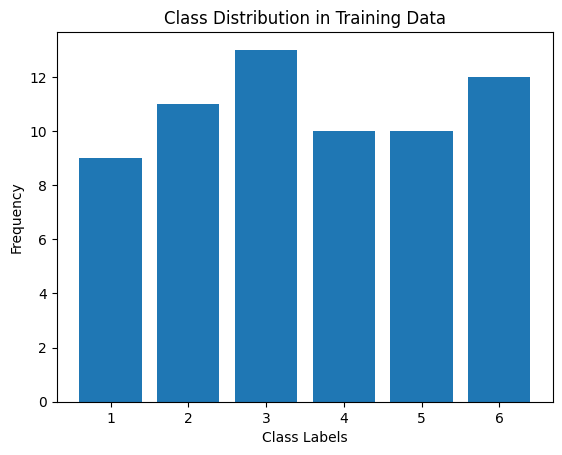

In [ ]:
import matplotlib.pyplot as plt
print(class_weights)
unique , counts = np.unique(y_train_segments, return_counts=True)
plt.bar(unique, counts)
plt.xlabel('Class Labels')
plt.ylabel('Frequency')
plt.title('Class Distribution in Training Data')
plt.show()

## Step 3 model training

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout,LSTM, GRU,BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping ,ReduceLROnPlateau
import tensorflow as tf
from tensorflow import keras



In [193]:

keras.backend.clear_session()
tf.keras.utils.set_random_seed(42)
# Convert the labels to categorical
y_train_split_cat = to_categorical(y_train_split-1)
y_val_split_cat = to_categorical(y_val_split-1)
y_test_cat = to_categorical(y_test_segments-1)


# Build a simple CNN model with Dropout layers
def build_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(64, kernel_size=3, activation='relu'),
        # BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.27),
        Conv1D(128, kernel_size=3, activation='relu'),
        # BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.27),
        LSTM(100, return_sequences=True),
        # Dropout(0.2),
        LSTM(100),
        Dropout(0.27),
        Dense(100, activation='relu'),
        # BatchNormalization(),
        # Dropout(0.3),
        Dense(6, activation='softmax')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
input_shape = (X_train_segments.shape[1], X_train_segments.shape[2])
model = build_model(input_shape)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 126, 64)        │       107,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 63, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 61, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 30, 100)        │        91,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 315,186 (1.20 MB)

 Trainable params: 315,186 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

In [194]:

# Define the training function outside the loop to avoid retracing
@tf.function(experimental_relax_shapes=True)
def model_predict(inputs):
    return model(inputs)

# class_weights = {0: 1.0, 1: 2.0}  # Class weights for ternary classification
# Train the model
history = model.fit(X_train_split, y_train_split_cat, epochs=50, 
                    batch_size=32, validation_data=(X_val_split, y_val_split_cat),
                    class_weight=class_weights_dict, callbacks=[early_stop,reduce_lr])

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 554ms/step - accuracy: 0.1883 - loss: 1.8187 - val_accuracy: 0.1538 - val_loss: 1.9377 - learning_rate: 0.0010
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.1546 - loss: 1.7962 - val_accuracy: 0.1538 - val_loss: 1.9197 - learning_rate: 0.0010
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.2965 - loss: 1.7463 - val_accuracy: 0.1538 - val_loss: 1.9767 - learning_rate: 0.0010
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.3093 - loss: 1.7126 - val_accuracy: 0.3077 - val_loss: 1.9056 - learning_rate: 0.0010
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.3141 - loss: 1.6202 - val_accuracy: 0.3077 - val_loss: 1.8786 - learning_rate: 0.0010
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.5232 - loss: 1.5528 - val_accuracy: 0.3077 - val_loss: 1.8673 - learning_rate: 0.0010
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.4688 - loss: 1.5310 - val_accuracy: 

## step 4 evalution

In [195]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
import json
# Evaluate the model
y_pred = model_predict(X_test_segments)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_cat, axis=1)

accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted',zero_division=0)
recall = recall_score(y_true_classes, y_pred_classes, average='weighted',zero_division=0)
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Confusion Matrix:\n{conf_matrix}')



Accuracy: 0.6956521739130435
Precision: 0.7210144927536232
Recall: 0.6956521739130435
F1 Score: 0.6927536231884057
Confusion Matrix:
[[3 0 1 0 0 0]
 [0 2 1 0 1 0]
 [0 1 2 0 0 0]
 [0 0 0 4 0 0]
 [0 0 0 2 3 0]
 [1 0 0 0 0 2]]


In [196]:
import json
# Save the evaluation metrics in a JSON file
metrics = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1': f1,
    'confusion_matrix': conf_matrix.tolist()
}

with open('../outputs/har_multiclass_classifier_metrics.json', 'w') as f:
    json.dump(metrics, f)

# Save the trained model
model.save('../outputs/har_multiclass_classifier.h5')